# ***PCA: Aplicado a los Resultados de las Pruebas Saber 11.***

# **Universidad Central**

# **Maestría en analítica de datos**

# **Métodos estadísticos para analítica de datos.**
# **Docente: Luis Andrés Campos Maldonado.**
# **Estudiante: Elizeth De La Cruz Rodriguez.**



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import warnings

from sklearn.decomposition import PCA            ## Principal component analysis
from sklearn.preprocessing import StandardScaler ## Estandarizar datos

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 9)
plt.style.use('ggplot')

In [ ]:
def view_index(df,indexs):
  """
    Esta función muestra la información del dataframe df proporcionando una lista de indexs.    
    Input: df: pandas-DataFrame 
           indexs: Lista con el índice o índices a seleccionar del DataFrame.
    Output: pandas-DataFrame con la información del índice o índices.
  """
  if len(indexs) == 1:
    return df.loc[indexs[0]].to_frame().T
  else:
    return pd.concat([df.loc[index,] for index in indexs], axis =1).T


In [ ]:
def sedimentacion(pca):
  """ Esta función genera un plot de sediemntación del objeto pca en el argumento
      Input: Objeto pca (from sklearn PCA)
      Ouput: None
  """
  expl_var = pca.explained_variance_ratio_
  str_componen = ["CP{}".format(i+1)  for i in range(0,len(expl_var))]
  df = pd.DataFrame({"componente": str_componen,
                     "% varianza": expl_var*100,
                     "% acumulada": np.cumsum(expl_var*100)})
  fig = px.bar(df, x = "componente",y = "% varianza",
               hover_data={"componente":False,
                           "% acumulada":True,
                           "% varianza":":.2f",
                           "% acumulada":":.2f"},
               hover_name = "componente",
               title = "Gráfico de sedimentación"
               )
  fig.show()

In [ ]:
def biplot(pca=None, dataframe=None, comp1=1, comp2=2,):
  """
    Esta función construye el biplot del correspodiente pca.
    Input:  pca: Objeto pca que se desea plotear.
            dataframe: pandas-DataFrame con el que se realizó el pca.
            comp1 = Componente en el eje x.
            comp2 = Compomente en el eje y
    Output: Biplot.
  """
  ## Trabajo con pca y dataframe.
  comp_1, comp_2 = str(comp1), str(comp2) ## Strings de las compomentes a plotear.
  vectores = pca.components_[[comp1-1,comp2-1]].T * np.sqrt(pca.explained_variance_[[comp1-1,comp2-1]])
  scaler, length = StandardScaler(), len(pca.explained_variance_)
  scaler.fit(dataframe)
  X_scaled = scaler.transform(dataframe)
  if dataframe.index.name == None:        ## En caso que el DataFrame no tenga nombre para el índice.
    dataframe.index.name = "Indice"
  pca_trans = pd.DataFrame(pca.transform(X_scaled), index = dataframe.index, 
                           columns = ["PC" + str(comp) for comp in range(1, length+1)])
  text_list = [pca_trans.index.name + ": {}".format(pca_trans.index[i]) for i in range(0,len(dataframe))]

  features = dataframe.columns
  ##
  fig = go.Figure()
  fig.add_trace(go.Scatter(x = pca_trans["PC"+ comp_1], y = pca_trans["PC"+comp_2], mode='markers',
                           hovertemplate ='<b>%{text}</b>' +'<br><br><b>PCX</b>: %{x:.2f}<br>'+
                           '<b>PCY</b>: %{y:.2f}<br>', name = "", text = text_list,))
  ## construcción del biplot.  
  for count, feature in enumerate(features):
    fig.add_annotation(x = vectores[count,0], y = vectores[count,1], ax = 0, ay = 0,
                       xref='x', yref='y',  axref='x',  ayref='y',  text='',showarrow=True, 
                       arrowhead=3, arrowsize=1, arrowwidth=1, arrowcolor='black')
    ##
    fig.add_annotation(x = vectores[count, 0], y = vectores[count, 1],ax = 0, ay = 0, xanchor = "center", 
                       text = feature, showarrow = True, arrowhead = 3, arrowcolor='rgb(255,51,0)',
                       font = dict(family = "Courier New, monospace", size = 10, color = "black"), 
                       yanchor = "bottom",)
  ## Personalización plot
  percent_var = pca.explained_variance_ratio_*100
  fig.update_layout(title = "Biplot.")
  fig.update_xaxes(range = [min(pca_trans["PC"+comp_1] - 0.2), max(pca_trans["PC"+comp_1]) + 0.2], 
                   title_text = "Dim "+ comp_1 + " ({:.2f}%)".format(percent_var[comp1-1]))  
  fig.update_yaxes(range = [min(pca_trans["PC"+comp_2] - 0.2), max(pca_trans["PC"+comp_2]) + 0.2],
                   title_text = "Dim "+ comp_2+ " ({:.2f}%)".format(percent_var[comp2-1]))
  fig.show()

In [ ]:
def plot_loadings_heatmap(pca, df_pca, n_compo = 2):
  """
      Esta función genera un heatmap de los loadings de las componentes pricipales que se tienen
      en el objeto pca que se recibe.
      Input:  pca: Objeto PCA (sklearn)
              df_pca: pandas DataFrame con quien se realizo el pca. O una lista de los nombres 
                      de igual cantidad que las compomentes principales del objeto pca ingresado.
              n_compo: Número de componentes principales, a las cuales se les desea ver sus loadings.
      Output: None
  """
  components = pca.components_[0:n_compo]
  yticks = [f"ACP{i}" for i in range(1,n_compo+1)]
  sns.heatmap(components, xticklabels = df_pca.columns, yticklabels = yticks, annot=True, cmap="PuBu")
  plt.title("Heatmap loadigns",fontsize = 10)
  plt.show()

## **1. Carga de Datos**

In [ ]:
url_main = "https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber"

df_icfes = pd.DataFrame()
for i in range(1,13):
  url = url_main + str(i) + ".csv"
  df_temp = pd.read_csv(url, sep = ";", encoding = "latin1", low_memory=False,index_col=0)
  print(url," Shape:",df_temp.shape)
  df_icfes = pd.concat([df_icfes,df_temp])

https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber1.csv  Shape: (10000, 77)
https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber2.csv  Shape: (10000, 77)
https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber3.csv  Shape: (10000, 77)
https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber4.csv  Shape: (10000, 77)
https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber5.csv  Shape: (10000, 77)
https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber6.csv  Shape: (10000, 77)
https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber7.csv  Shape: (10000, 77)
https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber8.csv  Shape: (10000, 77)
https://raw.githubusercontent.com/lacamposm/Metodos_Estadisticos/main/data/PruebaSaber9.csv  Shape: (100

In [ ]:
df_icfes.head()

,ESTU_GENERO,ESTU_FECHANACIMIENTO,ESTU_ESTUDIANTE,ESTU_PAIS_RESIDE,ESTU_DEPTO_RESIDE,ESTU_MCPIO_RESIDE,ESTU_ESTADOCIVIL,ESTU_TITULOOBTENIDOBACHILLER,ESTU_ANO_EXAMENESTADO_SB11,ESTU_SEMESTRE_EXAMENESTADOSB11,...,MOD_INGLES_DESEM,MOD_INGLES_PNAL,MOD_INGLES_PGREF,MOD_COMUNI_ESCRITA_PUNT,MOD_COMUNI_ESCRITA_DESEM,MOD_COMUNI_ESCRITA_PNAL,MOD_COMUNI_ESCRITA_PGREF,PUNT_GLOBAL,PERCENTIL_GLOBAL,ESTU_INSE_INDIVIDUAL
ESTU_NACIONALIDAD,,,,,,,,,,,,,,,,,,,,,
COLOMBIA,F,22/06/1991,ESTUDIANTE,COLOMBIA,VALLE,CALI,Soltero,Bachiller acadmico,2009,Primer semestre,...,-A1,17,27.0,104.0,3.0,53.0,61.0,94,36,44.584435
COLOMBIA,M,03/11/1994,ESTUDIANTE,COLOMBIA,LA GUAJIRA,FONSECA,Soltero,Bachiller tcnico,2012,Segundo semestre,...,A2,64,63.0,113.0,3.0,73.0,75.0,94,36,30.799276
COLOMBIA,F,03/11/1995,ESTUDIANTE,COLOMBIA,HUILA,NEIVA,Soltero,Bachiller acadmico,2012,Segundo semestre,...,A1,43,44.0,118.0,3.0,82.0,80.0,101,55,48.733856
COLOMBIA,F,20/11/1995,ESTUDIANTE,COLOMBIA,CAUCA,POPAYµN,Soltero,Bachiller acadmico,2012,Segundo semestre,...,A2,72,74.0,120.0,3.0,84.0,83.0,118,89,37.267822
COLOMBIA,M,28/08/1995,ESTUDIANTE,COLOMBIA,ATLANTICO,SOLEDAD,Soltero,Bachiller tcnico,2011,Segundo semestre,...,B1,94,95.0,104.0,3.0,53.0,50.0,121,92,42.739899


In [ ]:
DfPrincipal = pd.DataFrame()
        
DfPrincipal['PromMatematicas'] = df_icfes.groupby(["ESTU_DEPTO_RESIDE"]).MOD_RAZONA_CUANTITAT_PUNT.mean()
DfPrincipal['PromLenguage'] = df_icfes.groupby(["ESTU_DEPTO_RESIDE"]).MOD_LECTURA_CRITICA_PUNT.mean()
DfPrincipal['PromComEscrita'] = df_icfes.groupby(["ESTU_DEPTO_RESIDE"]).MOD_COMUNI_ESCRITA_PUNT.mean()
DfPrincipal['PromCSociales'] = df_icfes.groupby(["ESTU_DEPTO_RESIDE"]).MOD_COMPETEN_CIUDADA_PUNT.mean()
DfPrincipal['PromIngles'] = df_icfes.groupby(["ESTU_DEPTO_RESIDE"]).MOD_INGLES_PUNT.mean()

DfPrincipal 

,PromMatematicas,PromLenguage,PromComEscrita,PromCSociales,PromIngles
ESTU_DEPTO_RESIDE,,,,,
AMAZONAS,96.760000,98.680000,97.120000,105.440000,92.640000
ANTIOQUIA,99.043912,100.671538,101.705541,99.837631,98.516687
ARAUCA,97.640288,95.604317,92.007246,96.834532,91.906475
ATLANTICO,95.072551,95.236458,93.575103,94.271962,97.826130
BOGOTA,105.081044,104.861830,103.209002,105.170877,104.787360
BOLIVAR,95.422412,96.499260,95.751253,95.709067,97.806154
BOYACA,100.926884,100.459318,99.806305,100.985002,97.349456
CALDAS,97.700222,97.815350,101.410271,97.179644,98.015017
CAQUETA,94.247423,95.666667,100.481100,96.738832,90.783505


## **2. Análisis exploratorio de los Datos**

In [ ]:
df_icfes.dtypes

In [ ]:
print("Tamaño de la data:",df_icfes.shape,"\n\nValor nulos por feature:\n")
df_icfes.isna().sum()

In [ ]:
corre =DfPrincipal.corr()
plt.figure(figsize=(14, 14), dpi=80)
sns.heatmap(corre,annot=True )
plt.show()

AttributeError: ignored

## **3. Construcción de componentes principales**


In [ ]:
df_pca = DfPrincipal.dropna()                # Debemos trabajar con datos no nulos.
scaler = StandardScaler()           # Cargando el escalador estandar
scaler.fit(df_pca)                  # Calcula las medias y las desviaciones
X_scaled = scaler.transform(DfPrincipal) # Estandariza la data.
pd.DataFrame(X_scaled, index = DfPrincipal.index, columns = df_pca.columns)

,PromMatematicas,PromLenguage,PromComEscrita,PromCSociales,PromIngles
ESTU_DEPTO_RESIDE,,,,,
AMAZONAS,0.264609,0.681069,0.053338,2.131033,-0.767587
ANTIOQUIA,0.719249,1.105778,0.985499,0.789296,0.510490
ARAUCA,0.439841,0.025159,-0.985996,0.070070,-0.927116
ATLANTICO,-0.071297,-0.053289,-0.667278,-0.543652,0.360306
BOGOTA,1.921012,1.999387,1.291127,2.066580,1.874252
BOLIVAR,-0.001653,0.216012,-0.224905,-0.199473,0.355962
BOYACA,1.094077,1.060521,0.599417,1.064085,0.256638
CALDAS,0.451772,0.496677,0.925476,0.152723,0.401386
CAQUETA,-0.235549,0.038455,0.736592,0.047150,-1.171342


In [ ]:
pca = PCA()
pca.fit(X_scaled)                   
pca_array = pca.transform(X_scaled)

In [ ]:
name_columns = [f"PC{i+1}" for i in range(0,pca_array.shape[1])]
pca_trans =  pd.DataFrame(pca_array,  columns = name_columns)
pca_trans.head()

,PC1,PC2,PC3,PC4,PC5
0,-1.267041,-1.290982,1.151356,1.034182,0.005680
1,-1.870122,-0.037809,-0.162226,0.054231,-0.258492
2,0.462124,-0.841272,0.881490,-0.555445,0.154576
3,0.516002,0.544250,0.271356,-0.465058,-0.161810
4,-4.040319,0.695493,0.571576,0.024232,-0.056932


In [ ]:
sedimentacion(pca)

In [ ]:
pca.components_

array([[-0.48927133, -0.49472568, -0.45706163, -0.46995246, -0.29342702],
       [-0.12198592, -0.1523864 , -0.11606475, -0.19539655,  0.95406864],
       [ 0.1335832 ,  0.11733981, -0.83321825,  0.52194259,  0.04135423],
       [-0.64761858, -0.2639982 ,  0.27383522,  0.65881492,  0.04327015],
       [ 0.55540859, -0.80533298,  0.091571  ,  0.18575176, -0.00843372]])

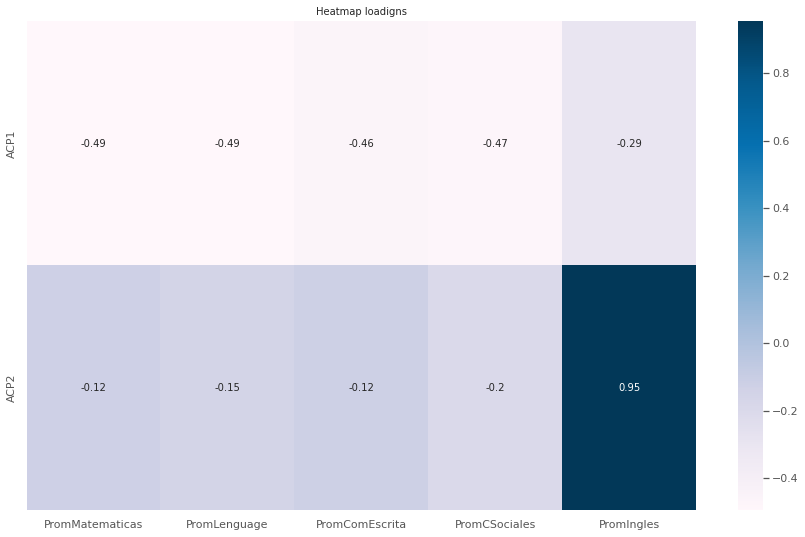

In [ ]:
plot_loadings_heatmap(pca,DfPrincipal,n_compo=2)

In [ ]:
pca = PCA(n_components = 2) 
pca.fit(X_scaled)
DfPrincipal = pca.transform(X_scaled)
pca_trans =  pd.DataFrame(DfPrincipal,columns = ["PC1","PC2"])
pca_trans.head()

,PC1,PC2
0,-1.267041,-1.290982
1,-1.870122,-0.037809
2,0.462124,-0.841272
3,0.516002,0.544250
4,-4.040319,0.695493


In [ ]:
pca_trans = pca.transform(X_scaled)
pca_trans =  pd.DataFrame(pca_trans, index = DfPrincipal.index, columns = ["PC1","PC2"])
pca_trans.head()

AttributeError: ignored

In [ ]:
print("Se ajustó un PCA a una data de tamaño:",DfPrincipal.shape)
print("Se obtuvo un ajuste por PCA de tamaño:",pca_trans.shape)
expl = pca.explained_variance_ratio_
print("Cantidad de varianza explicada: {:.3f}%".format(sum(expl[0:2])*100))

In [ ]:
pca_trans.corr()

In [ ]:
biplot(pca,DfPrincipal)